In [ ]:
# Import libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

import ast
import contractions
from wordcloud import WordCloud
import emoji
import re
import string 
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 
from nltk.tokenize import word_tokenize

  Using cached contractions-0.1.73-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached anyascii-0.3.2-py3-none-any.whl.metadata (1.5 kB)
  Using cached pyahocorasick-2.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
Using cached anyascii-0.3.2-py3-none-any.whl (289 kB)
Using cached pyahocorasick-2.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (119 kB)
  Using cached emoji-2.14.1-py3-none-any.whl.metadata (5.7 kB)
Using cached emoji-2.14.1-py3-none-any.whl (590 kB)
  Using cached wordcloud-1.9.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (539 kB)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Reload the Data
df = pd.read_csv('dataset/preprocessed_DatingAppReviewsDataset.csv')
df.head()
df.info()

,Id,neg,neu,pos,compound,Name,Review,Date&Time,App,Sentiment,Tokens
0,111028,0.074,0.926,0.000,-0.0516,Jasper Ancajas,i have a hard time logging in so i uninstalled...,2020-05-28 19:28:00,Tinder,negative,"['hard', 'time', 'log', 'uninstalled', 'app', ..."
1,211245,0.167,0.833,0.000,-0.2960,Tiger 181,i am getting no match and like...in stead of s...,2019-03-03 21:08:00,Tinder,negative,"['get', 'no', 'match', 'like', '...', 'stead',..."
2,9624,0.431,0.000,0.569,0.1779,Mr 21,no good,2021-02-03 21:38:00,Hinge,negative,"['no', 'good']"
3,198692,0.338,0.519,0.143,-0.4588,Tim Stone,"got banned for no reason, paid customer for ye...",2019-04-20 13:56:00,Tinder,negative,"['get', 'ban', 'no', 'reason', 'paid', 'custom..."
4,27599,0.180,0.755,0.065,-0.5057,Thelma Barbara,the more i use this app the more i am appalled...,2021-08-31 17:19:00,Tinder,negative,"['use', 'app', 'appalled', 'incredible', 'numb..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         50000 non-null  int64  
 1   neg        50000 non-null  float64
 2   neu        50000 non-null  float64
 3   pos        50000 non-null  float64
 4   compound   50000 non-null  float64
 5   Name       50000 non-null  object 
 6   Review     49950 non-null  object 
 7   Date&Time  50000 non-null  object 
 8   App        50000 non-null  object 
 9   Sentiment  50000 non-null  object 
 10  Tokens     50000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 4.2+ MB


After preprocessing, 50 reviews became empty after being saved to and reloaded from CSV. This happened because these reviews originally contained only non-text symbols, isolated hashtags, or non-English content. These empty reviews were retained in the dataset to preserve its structure, but they are not used in the final model training — they will remain available for exploratory data analysis (EDA) if needed. Since they account for just 0.1% of the data, they have no impact on model performance.

In [4]:
# Fill any missing (NaN) reviews with an empty string
df['Review'] = df['Review'].fillna('').astype(str)

# Convert the 'Tokens' column back into list
df['Tokens'] = df['Tokens'].apply(ast.literal_eval)

## EDA

Before building models, it’s important to understand the structure and sentiment trends within the dataset. To achieve this, the reviews were processed using VADER (Valence Aware Dictionary and sEntiment Reasoner) — a rule-based sentiment analysis tool designed specifically for short, informal text like customer reviews. VADER assigns each review a compound score summarising its overall sentiment, alongside individual scores for positive, neutral, and negative content. These scores will be used to explore sentiment patterns across the dating app reviews.

## Vader Sentiment Scoring

In [5]:
# The sentiment score and metadata
df.head()

,Id,neg,neu,pos,compound,Name,Review,Date&Time,App,Sentiment,Tokens
0,111028,0.074,0.926,0.000,-0.0516,Jasper Ancajas,i have a hard time logging in so i uninstalled...,2020-05-28 19:28:00,Tinder,negative,"[hard, time, log, uninstalled, app, not, insta..."
1,211245,0.167,0.833,0.000,-0.2960,Tiger 181,i am getting no match and like...in stead of s...,2019-03-03 21:08:00,Tinder,negative,"[get, no, match, like, ..., stead, spending, n..."
2,9624,0.431,0.000,0.569,0.1779,Mr 21,no good,2021-02-03 21:38:00,Hinge,negative,"[no, good]"
3,198692,0.338,0.519,0.143,-0.4588,Tim Stone,"got banned for no reason, paid customer for ye...",2019-04-20 13:56:00,Tinder,negative,"[get, ban, no, reason, paid, customer, year, ...."
4,27599,0.180,0.755,0.065,-0.5057,Thelma Barbara,the more i use this app the more i am appalled...,2021-08-31 17:19:00,Tinder,negative,"[use, app, appalled, incredible, number, scammer]"


## Plot Vader Results

<Axes: xlabel='Sentiment', ylabel='pos'>

<Axes: xlabel='Sentiment', ylabel='neu'>

<Axes: xlabel='Sentiment', ylabel='neg'>

Text(0.5, 1.0, 'Positive')

Text(0.5, 1.0, 'Neutral')

Text(0.5, 1.0, 'Negative')

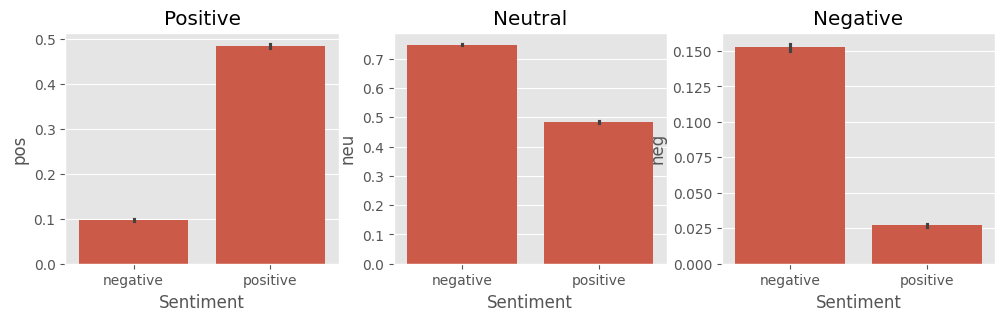

In [6]:
# Plot the VADER sentiment components across 3 sentiment classes
fig, axs = plt.subplots(1,3, figsize = (12,3))
sns.barplot(data=df, x = 'Sentiment', y='pos', ax=axs[0])
sns.barplot(data=df, x = 'Sentiment', y='neu', ax=axs[1])
sns.barplot(data=df, x = 'Sentiment', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

This plot compares VADER sentiment components (positive, neutral, negative) across the final sentiment classes: positive and negative. As expected, positive reviews show a much higher proportion of positive words, while negative reviews contain significantly more negative words. Interestingly, both classes still include a notable proportion of neutral words, with negative reviews oversampling the positive ones. A lot of those "neutral" reviews were actually mild complaints or disappointment, so they leaned more negative than truly neutral.

The strong separation of VADER sentiment scores across the two final sentiment classes (positive and negative) confirms that the decision to merge neutral reviews into the negative class aligns with the actual language used in these reviews. This reinforces that the simplified two-class approach effectively captures the sentiment patterns present in the data.

In [7]:
# Check the correlation between Sentiment and VADERs compound score

# Ratings were mapped into three sentiment classes, which later will be used for machine learning
sentiment_numeric = {
    'negative': -1,
    # 'neutral': 0,
    'positive': 1
}
df['Sentiment_Numeric'] = df['Sentiment'].map(sentiment_numeric)

correlation = df[['Sentiment_Numeric', 'compound']].corr()
print(correlation)

                   Sentiment_Numeric  compound
Sentiment_Numeric           1.000000  0.530904
compound                    0.530904  1.000000


The computed correlation coefficient of 0.53 indicates a moderate positive relationship between the sentiment labels (derived from ratings) and VADER’s compound sentiment score. This shows that VADER’s lexicon-based sentiment analysis generally aligns with user ratings, but the correlation is far from perfect.

This result is expected — VADER is designed to capture overall sentiment polarity, but it struggles with context, sarcasm, and multi-word expressions. These are common challenges in customer reviews, especially for informal text like app reviews. This limitation highlights the need for a more sophisticated machine learning model that can learn sentiment directly from the full text, rather than relying purely on predefined word sentiment scores.

https://medium.com/@suntarekar/vader-for-sentiment-analysis-a29f3f1dbcad
https://www.researchgate.net/publication/381650914_Understanding_Sentiment_Analysis_with_VADER_A_Comprehensive_Overview_and_Application

## Reviews

Text(0.5, 0, 'Sentiments')

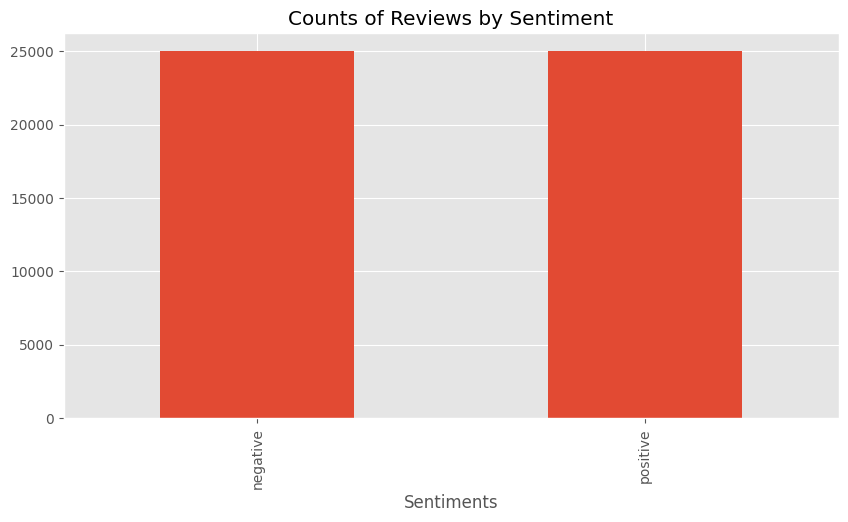

In [8]:
# Plot the count of reviews for each sentiment
review_by_rating = df['Sentiment'].value_counts().sort_index().plot(kind = 'bar', 
                                              title = 'Counts of Reviews by Sentiment',
                                              figsize = (10,5))
review_by_rating.set_xlabel('Sentiments')
plt.show()

The rating plot you showed is perfect evidence that your data is now balanced across sentiments.

## Tokens

In [9]:
df['TokenCount'] = df['Tokens'].apply(len)
print(df['TokenCount'].describe())

count    50000.000000
mean         9.134980
std         11.043193
min          0.000000
25%          2.000000
50%          5.000000
75%         12.000000
max        389.000000
Name: TokenCount, dtype: float64


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='TokenCount', ylabel='Count'>

Text(0.5, 1.0, 'Review Length Distribution (in Tokens)')

Text(0.5, 0, 'Number of Tokens')

Text(0, 0.5, 'Frequency')

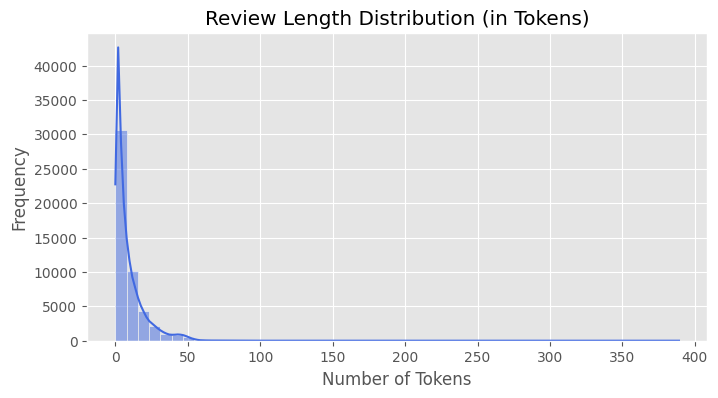

In [11]:
# Plot Review Length distribution (in Token Counts)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

# Histogram for review lengths
sns.histplot(df['TokenCount'], bins=50, kde=True, color='royalblue')

plt.title('Review Length Distribution (in Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

This analysis examines the length of reviews after preprocessing, measured in tokens (cleaned words). The distribution is heavily right-skewed, with the majority of reviews containing fewer than 100 tokens. However, a small proportion of reviews extend well beyond 500 tokens, with extreme cases exceeding 1000 tokens.

This skew reflects a common pattern in user-generated content — most users leave short, to-the-point reviews, while a smaller group provides much longer, more detailed feedback. These long reviews could contain rich sentiment information (especially in negative feedback, where users may rant), or they could represent noise, such as copied content, disclaimers, or irrelevant text.

<Axes: xlabel='Sentiment', ylabel='TokenCount'>

Text(0.5, 1.0, 'Review Length by Sentiment (in Tokens)')

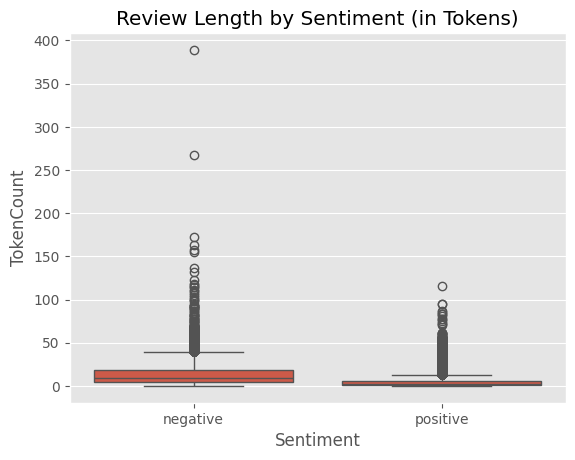

                   Sentiment_Numeric  TokenCount
Sentiment_Numeric            1.00000    -0.36941
TokenCount                  -0.36941     1.00000


In [14]:
# Plot Review length by each Sentiment
import seaborn as sns

sns.boxplot(x='Sentiment', y='TokenCount', data=df)
plt.title('Review Length by Sentiment (in Tokens)')
plt.show()


corr = df[['Sentiment_Numeric', 'TokenCount']].corr()
print(corr)

To explore the relationship between review length and sentiment class, the average length of reviews (measured in tokens) was computed separately for each sentiment category (positive, negative). Across the dataset, negative reviews tend to be slightly longer on average, with positive reviews being shorter and more concise.
This pattern aligns with common user behavior — negative feedback often contains detailed explanations or complaints, while positive feedback is typically more to the point.
A correlation analysis between review length and the numeric sentiment class (where negative = -1, positive = +1) revealed only a weak negative correlation, indicating that review length alone is not a strong predictor of sentiment. This confirms that while there is a slight tendency for negative reviews to be longer, sentiment prediction requires deeper linguistic analysis, reinforcing the need for proper text-based features.
As a result, review length may be included as a secondary feature in the final model (as an option), but the primary predictive signal will come from the actual content of the review text itself.

<Figure size 600x300 with 0 Axes>

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

Text(0.5, 1.0, 'Top 20 Words in Reviews')

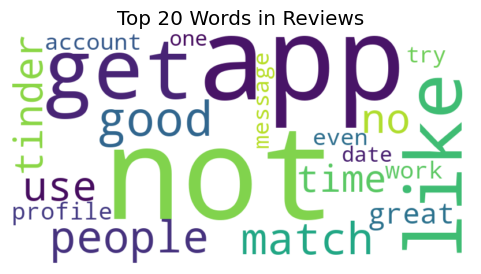

In [27]:
# Top 20 words in Reviews
all_tokens = [token for tokens in df['Tokens'] for token in tokens]
counter = Counter(all_tokens)
most_common = counter.most_common(20) 
word_freq_dict = dict(most_common)

wordcloud = WordCloud(
    width=800, height=400, background_color='white'
).generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(6, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Words in Reviews')
plt.show()

<Figure size 1600x1200 with 0 Axes>

<Axes: >

/tmp/ipykernel_1279/2328705735.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


<Axes: >

Text(0.5, 1.0, 'Top 10 Words in Negative Reviews')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

<Axes: >

/tmp/ipykernel_1279/2328705735.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


<Axes: >

Text(0.5, 1.0, 'Top 10 Words in Positive Reviews')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Word')

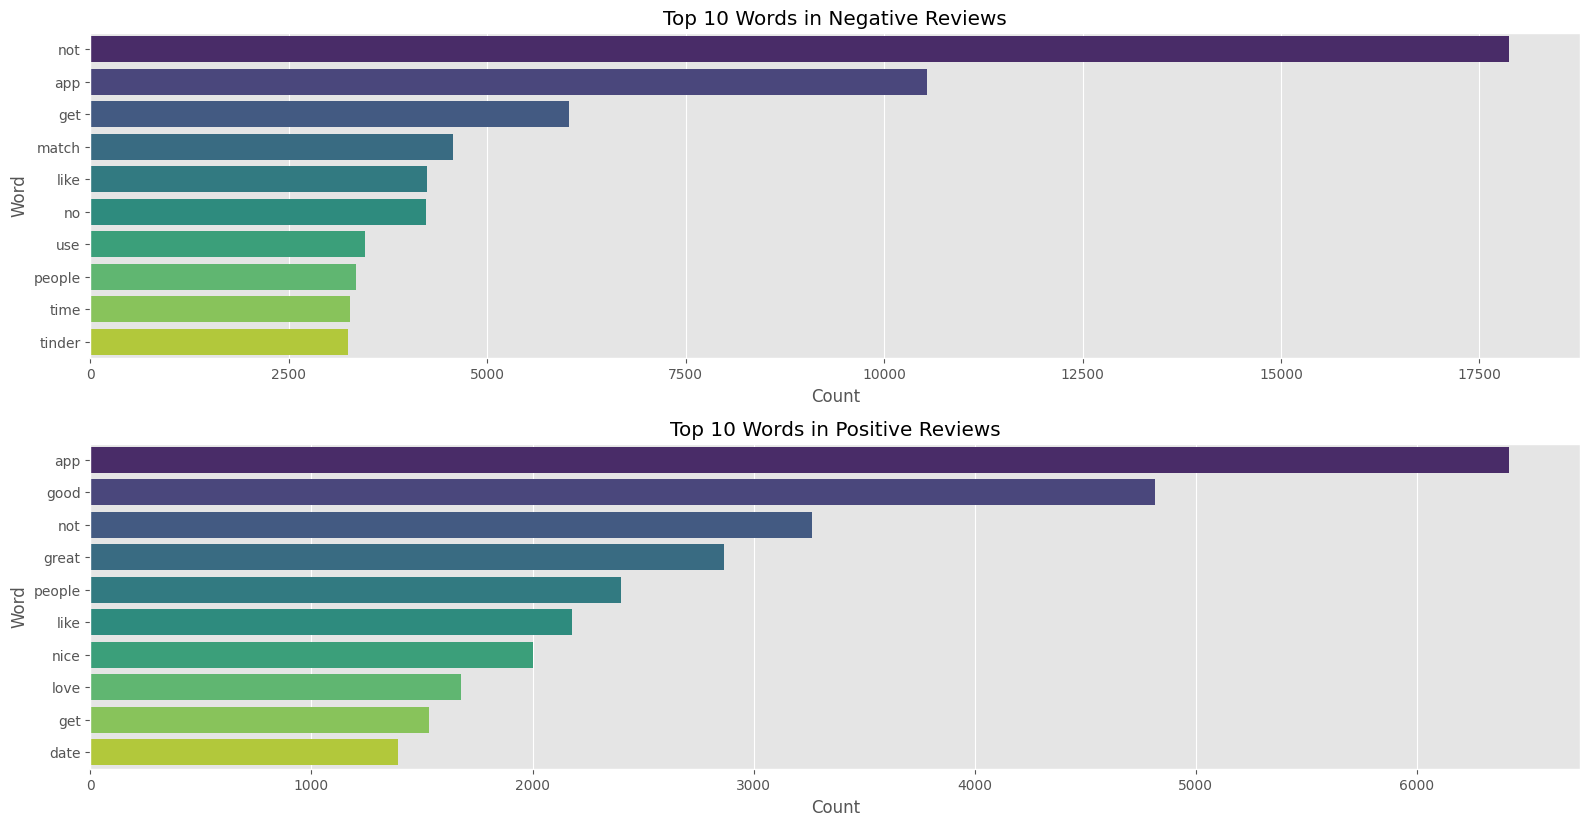

In [28]:
# Top 10 words for each sentiment class
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Collect word counts by sentiment
class_word_counts = defaultdict(Counter)

for tokens, sentiment in zip(df['Tokens'], df['Sentiment']):
    class_word_counts[sentiment].update(tokens)

# Plot
plt.figure(figsize=(16, 12))

for i, (sentiment, counter) in enumerate(class_word_counts.items(), 1):
    top_words = counter.most_common(10)
    words = [word for word, _ in top_words]
    counts = [count for _, count in top_words]

    plt.subplot(3, 1, i)
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(f"Top 10 Words in {sentiment.capitalize()} Reviews")
    plt.xlabel('Count')
    plt.ylabel('Word')

plt.tight_layout()
plt.show()

Initial exploratory analysis focused on unigram word frequency, identifying common words used in positive, negative reviews. However, sentiment often depends on word combinations rather than individual terms — for example, the word "good" has a different meaning in the phrase "not good" than it does alone. Therefore, the analysis was extended to bigrams to capture important sentiment-related phrases.

<Figure size 1600x1200 with 0 Axes>

<Axes: >

/tmp/ipykernel_1279/2752190797.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigram_labels, palette='viridis')


<Axes: >

Text(0.5, 1.0, 'Top 10 Bigrams in Negative Reviews')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Bigram')

<Axes: >

/tmp/ipykernel_1279/2752190797.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigram_labels, palette='viridis')


<Axes: >

Text(0.5, 1.0, 'Top 10 Bigrams in Positive Reviews')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Bigram')

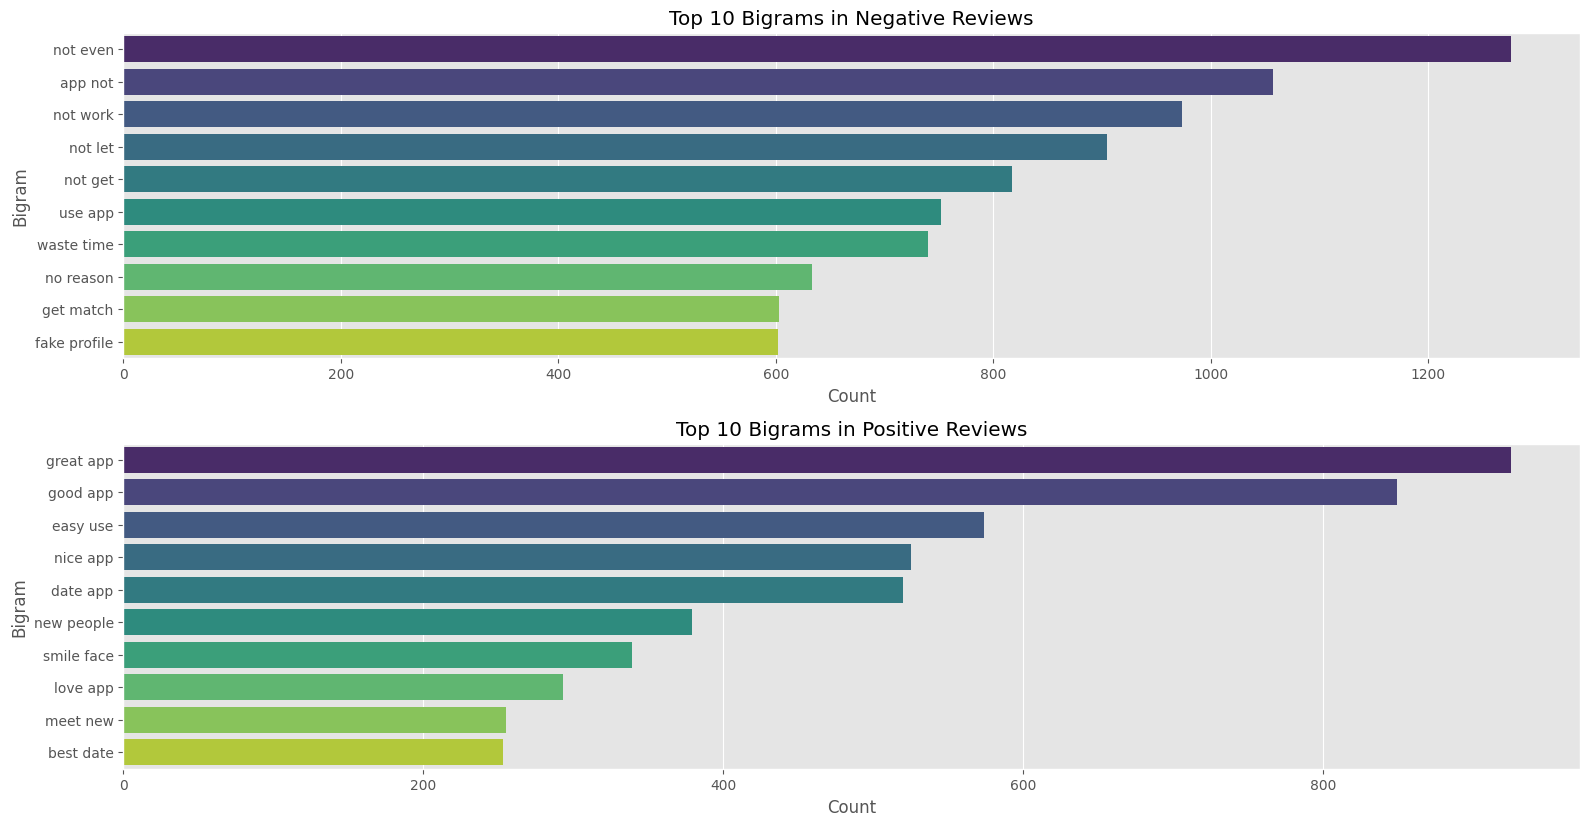

In [29]:
# Plot top bigrams for each sentiment class
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from nltk.util import ngrams

# Collect bigrams by sentiment
class_bigram_counts = defaultdict(Counter)

for tokens, sentiment in zip(df['Tokens'], df['Sentiment']):
    bigrams = list(ngrams(tokens, 2))
    class_bigram_counts[sentiment].update(bigrams)

# Plot
plt.figure(figsize=(16, 12))

for i, (sentiment, counter) in enumerate(class_bigram_counts.items(), 1):
    top_bigrams = counter.most_common(10)

    bigram_labels = [' '.join(bigram) for bigram, _ in top_bigrams]
    counts = [count for _, count in top_bigrams]

    plt.subplot(3, 1, i)
    sns.barplot(x=counts, y=bigram_labels, palette='viridis')
    plt.title(f"Top 10 Bigrams in {sentiment.capitalize()} Reviews")
    plt.xlabel('Count')
    plt.ylabel('Bigram')

plt.tight_layout()
plt.show()

Analyzing bigrams helps uncover contextual meaning that would be lost if only individual words were considered. For example, “not work” carries clear negative meaning, which “work” alone doesn’t. In negative reviews, bigrams like “waste time” and “fake profile” highlight common complaints. In positive reviews, bigrams like “great app” and “best date” show what users value most. This confirms that bigrams are useful for understanding sentiment, especially in short reviews where context matters. 
https://www.oreilly.com/library/view/text-mining-with/9781491981641/ch04.html#:~:text=Using%20Bigrams%20to%20Provide%20Context%20in%20Sentiment%20Analysis&text=For%20example%2C%20the%20words%20“happy,a%20word%20like%20“not.” 

In [ ]:
df.to_csv('dataset/afterEDA_DatingAppReviewsDataset.csv', index=False)